In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from joblib import Parallel, delayed
from pyvbmc import VBMC
import corner


from scipy.integrate import quad
from tied_utils import tied_data_gen_wrapper, rho_E_minus_small_t_NORM_TIED_fn, rho_E_plus_small_t_NORM_TIED_fn, rho_E_small_t_NORM_TIED_fn


In [2]:
# read out_LED.csv as dataframe
og_df = pd.read_csv('../out_LED.csv')

# chose non repeat trials - 0 or 2 or missing
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]

# only session type 7
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]

# training level 16
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

In [3]:
# find ABL and ILD
ABL_arr = df['ABL'].unique()
ILD_arr = df['ILD'].unique()


# sort ILD arr in ascending order
ILD_arr = np.sort(ILD_arr)
ABL_arr = np.sort(ABL_arr)

print('ABL:', ABL_arr)
print('ILD:', ILD_arr)

ABL: [20 40 60]
ILD: [-16.  -8.  -4.  -2.  -1.   1.   2.   4.   8.  16.]


In [4]:
# LED off rows
df_1 = df[ df['LED_trial'] == 0 ]
# animal rows
animal = 100
df_1 = df_1[ df_1['animal'] == animal ]
print(f' len of df_1 {len(df_1)}')

 len of df_1 6227


# VBMC

## timed fix trunc factor and rt factor

In [5]:
T_trunc_timed_fix = 0.3

## loglike

In [6]:
def compute_loglike(row, rate_lambda, theta_E, T_0, t_non_decision):
    timed_fix = row['timed_fix']
    intended_fix = row['intended_fix']

    ILD = row['ILD']
    ABL = row['ABL']

    choice = row['response_poke']
    rt = timed_fix - intended_fix
     
    
    K_max = 10

    # change units back to seconds from ms
    T_0 *= 1e-3
    t_non_decision *= 1e-3

    try:
        trunc_factor = 1 / (1 - quad(rho_E_small_t_NORM_TIED_fn, 0, T_trunc_timed_fix, args=(ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max))[0]) 
    except Exception as e:
        trunc_factor = 0
        

    

    if choice == 3:
        likelihood = rho_E_plus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) * trunc_factor
    elif choice == 2:
        likelihood = rho_E_minus_small_t_NORM_TIED_fn(rt, ILD, ABL, rate_lambda, theta_E, T_0, t_non_decision, K_max) * trunc_factor


    if likelihood <= 0:
        likelihood = 1e-50

    
    return np.log(likelihood)    


def tied_loglike_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    all_loglike = Parallel(n_jobs=-1)(
                                     delayed(compute_loglike)(row, rate_lambda, theta_E, T_0, t_non_decision)\
                                        for _, row in df_1.iterrows() 
                                        if ( (row['response_poke'] in [2,3])  and (row['timed_fix'] > T_trunc_timed_fix) and (row['timed_fix'] > row['intended_fix'])  )
                                    )

    loglike = np.sum(all_loglike)
    # if loglike is nan , stop the process
    if np.isnan(loglike):
        print('nan loglike')
        
    return loglike

## Bounds

In [7]:
rate_lambda_bounds = [0.01, 0.2]
T_0_bounds = [0.1, 0.8] #  ms
theta_E_bounds = [35, 65]
t_non_decision_bounds = [60, 90] # ms

rate_lambda_plausible_bounds =  [0.05, 0.09]
T_0_plausible_bounds = [0.15, 0.5] #  ms
theta_E_plausible_bounds = [40, 55]
t_non_decision_plausible_bounds = [70, 80] # ms

## prior

In [8]:
def trapezoidal_logpdf(x, a, b, c, d):
    if x < a or x > d:
        return -np.inf  # Logarithm of zero
    area = ((b - a) + (d - c)) / 2 + (c - b)
    h_max = 1.0 / area  # Height of the trapezoid to normalize the area to 1
    
    if a <= x <= b:
        pdf_value = ((x - a) / (b - a)) * h_max
    elif b < x < c:
        pdf_value = h_max
    elif c <= x <= d:
        pdf_value = ((d - x) / (d - c)) * h_max
    else:
        pdf_value = 0.0  # This case is redundant due to the initial check

    if pdf_value <= 0.0:
        return -np.inf
    else:
        return np.log(pdf_value)
    

def tied_prior_fn(params):
    rate_lambda, theta_E, T_0, t_non_decision = params

    rate_lambda_logpdf = trapezoidal_logpdf(rate_lambda, rate_lambda_bounds[0], rate_lambda_plausible_bounds[0], \
                                            rate_lambda_plausible_bounds[1], rate_lambda_bounds[1])
    theta_E_logpdf = trapezoidal_logpdf(theta_E, theta_E_bounds[0], theta_E_plausible_bounds[0], \
                                            theta_E_plausible_bounds[1], theta_E_bounds[1])
    T_0_logpdf = trapezoidal_logpdf(T_0, T_0_bounds[0], T_0_plausible_bounds[0], \
                                            T_0_plausible_bounds[1], T_0_bounds[1])
    t_non_decision_logpdf = trapezoidal_logpdf(t_non_decision, t_non_decision_bounds[0], t_non_decision_plausible_bounds[0], \
                                            t_non_decision_plausible_bounds[1], t_non_decision_bounds[1])
    
    return rate_lambda_logpdf + theta_E_logpdf + T_0_logpdf + t_non_decision_logpdf

## prior + likelihood

In [9]:
def tied_joint_fn(params):
    return tied_loglike_fn(params) + tied_prior_fn(params)

## run vbmc

In [10]:
lb = np.array([rate_lambda_bounds[0], theta_E_bounds[0], T_0_bounds[0], t_non_decision_bounds[0]])
ub = np.array([rate_lambda_bounds[1], theta_E_bounds[1], T_0_bounds[1], t_non_decision_bounds[1]])
plb = np.array([rate_lambda_plausible_bounds[0], theta_E_plausible_bounds[0], T_0_plausible_bounds[0], t_non_decision_plausible_bounds[0]])
pub = np.array([rate_lambda_plausible_bounds[1], theta_E_plausible_bounds[1], T_0_plausible_bounds[1], t_non_decision_plausible_bounds[1]])

np.random.seed(42)
rate_lambda_0 = np.random.uniform(rate_lambda_plausible_bounds[0], rate_lambda_plausible_bounds[1])
theta_E_0 = np.random.uniform(theta_E_plausible_bounds[0], theta_E_plausible_bounds[1])
T_0_0 = np.random.uniform(T_0_plausible_bounds[0], T_0_plausible_bounds[1])
t_non_decision_0 = np.random.uniform(t_non_decision_plausible_bounds[0], t_non_decision_plausible_bounds[1])

x0 = np.array([rate_lambda_0, theta_E_0, T_0_0, t_non_decision_0])

vbmc = VBMC(tied_joint_fn, x0, lb, ub, plb, pub, options={'display': 'off'})
vp, results = vbmc.optimize()

Reshaping x0 to row vector.
Reshaping lower bounds to (1, 4).
Reshaping upper bounds to (1, 4).
Reshaping plausible lower bounds to (1, 4).
Reshaping plausible upper bounds to (1, 4).


/home/rka/code/ddm_data/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar subtract
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),
/home/rka/code/ddm_data/venv/lib/python3.10/site-packages/cma/evolution_strategy.py:3379: RuntimeWarning: invalid value encountered in scalar multiply
  current_fitness_range < opts['tolfunrel'] * (es.fit.median0 - es.fit.median_min),


Inference terminated: reached maximum number of function evaluations options.max_fun_evals.
Estimated ELBO: 37427.207 +/-8862.393.
Caution: Returned variational solution may have not converged.


## corner plots

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


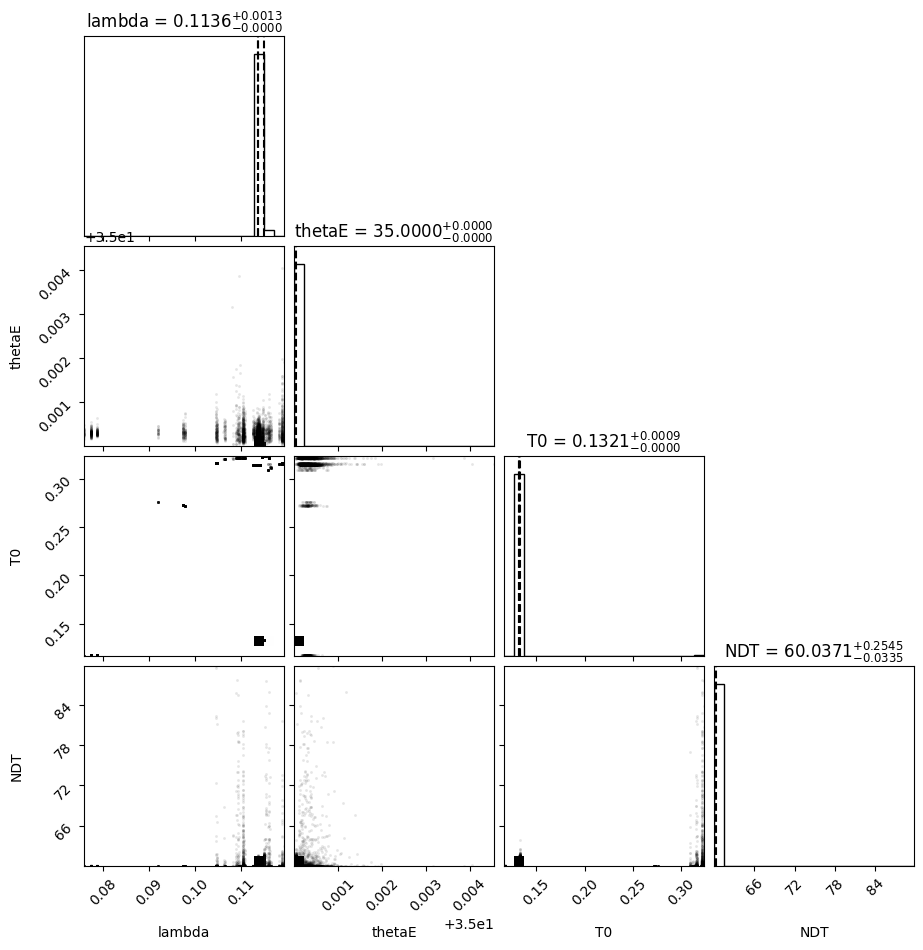

In [13]:
vp_samples = vp.sample(int(1e6))[0]

rate_lambda_samp = vp_samples[:, 0]
theta_E_samp = vp_samples[:, 1]
T_0_samp = vp_samples[:, 2]
t_non_decision_samp = vp_samples[:, 3]

combined_samples = np.transpose(np.vstack((rate_lambda_samp, theta_E_samp, T_0_samp, t_non_decision_samp)))
param_labels = ['lambda', 'thetaE', 'T0', 'NDT']

corner.corner (combined_samples, labels=param_labels, show_titles=True, quantiles=[0.025, 0.5, 0.975], title_fmt=".4f"  );


# mean vp param

In [ ]:
# get mean of samples
mean_vb_params = {}
for i, label in enumerate(param_labels):
    mean_vb_params[label] = np.mean(vp_samples[:, i])

mean_vb_params['T0'] = mean_vb_params['T0'] * 1e-3 # s
mean_vb_params['NDT'] = mean_vb_params['NDT'] * 1e-3 # s

# diagnostics

In [ ]:
t_stim_0 = 0.2
t_stim_tau = 0.4
N_print = int(1e5)
N_sim = int(1e6)
dt = 1e-4

sim_results = Parallel(n_jobs=-1)(delayed(tied_data_gen_wrapper)(ILD_arr, ABL_arr, \
                                                                 mean_vb_params['lambda'], mean_vb_params['thetaE'], mean_vb_params['T0'], mean_vb_params['NDT'], \
                                                                  t_stim_0, t_stim_tau, iter_num, N_print, dt
                                                                )

                                                                        for iter_num in range(N_sim) !
                                                                        )